## Imports & function definitions

In [ ]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import squidpy as sq


from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from sklearn.cluster import KMeans

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


In [ ]:
# This is the publication iteration of regions
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)

# Create color legend
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

In [ ]:

# Define functions
def get_spot_interfaces(dat, cluster_of_interest, interaction_cluster, annotation_key = 'predicted_region',added_key='proximity_analysis'):

    # Create an observation column for spatial segmentation
    dat.obs[added_key] = np.nan
    distance_mat = dat.obsp['spatial_distances'].todense()

    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[annotation_key][idx]

        if cl == cluster_of_interest:

            first_nhbor_idxs = np.where(distance_mat[:,idx]==1.0)[0] # Get first-term neighbor indices

            try:
                # If try fails, there are no matching clusters as keys in value_counts
                n_cl_neighbors = dat[first_nhbor_idxs].obs[annotation_key].value_counts()[cl] # find first-term neighbor cluster annotations POSSIBLE ERROR IF CL NOT IN DICT

                # Added this clause to control that only those with 'close' interactions with the interaction cluster are included. 
                all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0]

                # Downgraded the number of required first neighbors to one
                if (n_cl_neighbors >= 1) & (sum(dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster) >= 2):
                    dat.obs.at[obs_name,added_key] = cl

            except:
                continue

    # Make a second loop to make sure the final cluster-of-interest annotations
    # are what's used to define proximal spots
    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[added_key][idx]

        if cl == cluster_of_interest:
            
            all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0] 

            # Get the indices where neighboring spots are not the interest cluster 
            indices = np.where((dat.obs[added_key][all_nhbor_indices] != cl) & (dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster))[0]

            # Update the 'proximity_analysis' column for the specific indices
            dat.obs.loc[dat.obs_names[all_nhbor_indices[indices]], added_key] = interaction_cluster

    # Modify the colors to maintain the original cluster color
    dat.obs[added_key] = dat.obs[added_key].astype('category')

    return(dat)



def most_common_interactions(dct):
    tuple_lst = []
    for key in dct.keys():
        [tuple_lst.append(tup) for tup in dct[key]]
    res = pd.Series(tuple_lst).value_counts()
    return(res)

def merge_dicts(dict1, dict2):
    merged_dict = {}

    for key, value in dict1.items():
        if key in dict2:
            merged_dict[key] = [value, dict2[key], value - dict2[key]]
        else:
            merged_dict[key] = [value, 0, value]

    for key, value in dict2.items():
        if key not in merged_dict:
            merged_dict[key] = [0, value, 0 - value]

    return merged_dict


## Subset proximal spots, calculate receptor-ligand analysis and plot

In [ ]:
import matplotlib.patches as patches

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

In [ ]:
from itertools import combinations
essential_region_combinations = list(combinations(regions[:5],2))
essential_region_combinations

rest_region_combinations = list(combinations(regions,2))

In [ ]:
for tup in rest_region_combinations:
    source = tup[0]
    target = tup[1]
    valid_samples = []

    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            # There are at least 10 of both regions
            if it < len(samples) :
                
                slide = adata_slides[samples[it]]
                # Using three rings you get 6 immediate neigbors, 12 second neigbors and 18 third neighbors
                sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)

                # First check to see if there are sufficient amount of spots to look for proximal ones
                if (slide.obs['predicted_region'].str.contains(source).sum() >= 10) & (slide.obs['predicted_region'].str.contains(target).sum() >= 10):
                    
                    slide = get_spot_interfaces(slide, source, target)

                    if not (slide.obs['proximity_analysis'].isna().all()):
                        # Second check to see if there are sufficient amount of spots to plot and do ligrec (10)
                        if (slide.obs['proximity_analysis'].str.contains(source).sum() >= 10) & (slide.obs['proximity_analysis'].str.contains(target).sum() >= 10):

                            ## Plotting ##
                            slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

                            # create spatial plot
                            sc.pl.spatial(slide,color='proximity_analysis',title=samples[it],
                                                    crop_coord=sample_crop_coord[samples[it]],
                                                    size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                                                    ax=axs[i,j],show=False
                                                    )
                            axs[i,j].set_xlabel(None)
                            axs[i,j].set_ylabel(None)

                            # Append this sample to the list
                            valid_samples.append(samples[it])

                        else:
                            axs[i,j].set_visible(False)
                    else:
                        axs[i,j].set_visible(False)
                else:
                    axs[i,j].set_visible(False)
            else:
                axs[i,j].set_visible(False)
            
            it+=1


    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=4,fontsize='xx-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=4,fontsize='xx-large')

    plt.savefig('./plots/receptor_ligand_interaction_analysis/'+source.replace(' ','_')+'_'+target.replace(' ','_')+'_proximity_regions.pdf')
    plt.clf()


    #### Second part, using valid_samples to do ligrec #####
    ligrec_dict = {}
    for sample in valid_samples:

        if len(adata_slides[sample].obs['proximity_analysis'].unique()) >=3:
            slide = adata_slides[sample].copy()
            slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].cat.add_categories(['NA'])
            slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].fillna('NA')

            ligrec_res = sq.gr.ligrec(
                slide,
                cluster_key='proximity_analysis',
                clusters = [source,target],
                show_progress_bar = False,
                seed=25234169,
                copy=True
            )

            ligrec_dict[sample] = ligrec_res

    save_to_pickle(ligrec_dict,'./data/region_ligrec_analysis/'+source.replace(' ','_')+'_'+target.replace(' ','_')+'_slides_with_ligrec.pkl')

    print('')
    print('')
    print(source+ ' <--> ' + target + ' done!')



In [ ]:
# Saving figures in high resolution
sc.set_figure_params(figsize=(3,3),dpi_save=1200)

#for sample in ['PC_06_04581_OIK_POST_0']:

sample = 'PC_06_04581_OIK_POST_0'
slide = adata_slides[sample].copy()
it= 0

for i in range(2):
    for j in range(4):
        
        region_of_interest = regions[it]
            
        slide.obs['region_of_interest'] = np.nan

        slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

        slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

        slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

    
        n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

        sc.pl.spatial(slide,color='region_of_interest',
                crop_coord=sample_crop_coord[sample],
                size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                save=sample+'_'+region_of_interest+'.pdf',show=False
            )
        it += 1

In [ ]:
# Saving figures in high resolution
sc.set_figure_params(figsize=(3,3),dpi_save=1200)

#for sample in ['PC_06_04581_OIK_POST_0']:

sample = 'PC_06_04581_OIK_POST_0'
regions_to_plot = [t for t in list(combinations(regions,2)) if 'Tumor' in t]


for tup in regions_to_plot:
    source = tup[0]
    target = tup[1]
    
    slide = adata_slides[sample].copy()
    sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)
        
    slide = get_spot_interfaces(slide, source, target)
    
    slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

    sc.pl.spatial(slide,color='proximity_analysis',crop_coord=sample_crop_coord[sample],title='',
                        size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',show=False,
                        save=sample+'_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'.pdf'
                        )

## Loading the data from pickle for analysis

In [ ]:
def get_ligrec_results(results_dict,source_region, target_region, pval = 0.01,reverse=False):
    # Function only reports those means that have a below-threshold p-value

    if reverse:
        source = source_region
        source_region = target_region
        target_region = source

    for i,s in enumerate(list(results_dict.keys())):
        means = results_dict[s]['means'][source_region][target_region]
        pvals = results_dict[s]['pvalues'][source_region][target_region]
        means = pd.DataFrame(means[pvals[pvals<pval].index])
        means = means.rename(columns={target_region:s})
        meta = results_dict[s]['metadata'].loc[means.index]

        if i==0:
            means_all = means
            metas_all = meta
        else:
            means_all = pd.merge(means_all,means,how='outer',left_index=True,right_index=True)
            metas_all = pd.concat([metas_all,meta],axis=0)

    # Drop duplicate indices
    metas_all.drop_duplicates(inplace=True)
    # Option of returning the results dict if needed
    return means_all, metas_all

def filter_ligrec_results(ligrec_res_dict,valid_samples):
    for k in list(ligrec_res_dict.keys()):
        df = ligrec_res_dict[k].copy()
        df = df[[c for c in df.columns if c in valid_samples]]
        ligrec_res_dict[k] = df
    
    return(ligrec_res_dict)


def format_dotplot_df(plot_df, interfaces, n_interactions_per_interface=10, filter_by_n_regions=0,filter_duplicates = True):
    
    plot_df = plot_df[plot_df['interaction'].isin(interfaces)]
    # Filter out interactions that are present in all
    if filter_by_n_regions:
        val_counts = plot_df['molecules'].value_counts()
        not_in_all_regions_idxs = val_counts[val_counts < len(interfaces)-filter_by_n_regions].index
        plot_df = plot_df.loc[not_in_all_regions_idxs]

    final_idxs_list = []

    for k in interfaces:

        df = plot_df[plot_df['interaction'] == k].sort_values(['pct_in','mean'],ascending=False)

        ####### R/L DUPLICATE FILTERING BEGINS HERE ######
        if filter_duplicates:
            l_list = []
            r_list = []
            valid_idxs = []
            for idx,tup in enumerate(df['molecules']):
                if ((tup[0] not in l_list) & (tup[1] not in r_list)):
                    l_list.append(tup[0])
                    r_list.append(tup[1])
                    valid_idxs.append(idx)

            df = df.iloc[valid_idxs]
        ####### STOPS HERE ######   

        final_idxs_list += df[:n_interactions_per_interface].sort_index().index.tolist()

    plot_df = plot_df.loc[pd.Series(final_idxs_list).unique().tolist()]
    plot_df.loc[plot_df['pct_in'] == 0,'pct_in'] = np.nan

    return(plot_df)


In [118]:
roi = 'Immune' # Original source region. Flip the reverse switch on if you intend this to be the target
reverse_switch = True # Set to true if wish to look at the reverse interaction

orig_combs = list(combinations(regions,2))
prox_regions = [t for t in orig_combs if roi in t]


# Immune comparisons
#prox_regions = [('Tumor','Immune'),('Luminal epithelium','Immune'),('Basal epithelium','Immune'),('Intermediate epithelium','Immune'),]


## Download ligrec results and their metadata
ligrec_results = {}
meta_all = pd.DataFrame()

for reg_couple in prox_regions:
    r1 = reg_couple[0]
    r2 = reg_couple[1]
    key = r1.replace(' ','_') + '_' + r2.replace(' ','_')

    # Load the data
    results_dict = load_from_pickle('./data/region_ligrec_analysis/'+r1.replace(' ','_')+'_'+r2.replace(' ','_')+'_slides_with_ligrec.pkl')

    # Flip the direction if the region of interest (ROI) is second. This matches the direction of all comparisons, but can still be reversed if reverse_switch = True
    if roi == r2:
        r_temp = r2
        r2 = r1
        r1 = r_temp

    df,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=reverse_switch)
    ligrec_results[key] = df
    meta_all = pd.concat([meta_all,meta],axis=0)

keys = list(ligrec_results.keys())
meta_all.drop_duplicates(inplace=True)

# Filtering samples
sample_list = get_sample_ids_reorder(['BPH','untreated'])
#sample_list = get_sample_ids_reorder(['bicalutamide','goserelin','CRPC'])

# Filter out samples that are not of interest
ligrec_results = filter_ligrec_results(ligrec_results,sample_list)


## Summarize the ligand-receptor pair results
summarized_ligrec_results = {}
for k in keys:
    df = ligrec_results[k].copy()
    n_samples = df.shape[1]
    pct_active = (~df.isna()).sum(axis=1)#/n_samples ######## Here you can affect whether you look at percentages or numbers of samples
    mean_activity = df.mean(axis=1)
    summarized_df = pd.DataFrame({'mean':mean_activity,'pct_in':pct_active,'interaction':k})
    summarized_ligrec_results[k] = summarized_df

summarized_ligrec_df = pd.concat(summarized_ligrec_results.values(),axis=0)


# Filtering interactions according to metadata annotation
meta = meta_all.copy()
accepted_sources = ['CellPhoneDB']
#meta = meta[meta['sources'].isin(accepted_sources)]
#meta = meta[(meta['secreted_intercell_source'] | meta['transmitter_intercell_source'])]
meta = meta[(meta['consensus_score_intercell_target']>10) & (meta['consensus_score_intercell_source']>10)]
summarized_ligrec_df = summarized_ligrec_df.loc[meta.index.drop_duplicates()]
summarized_ligrec_df['molecules'] = list(summarized_ligrec_df.index)

print('Sample numbers:')
for k in keys:
    print(k + ': ' + str(ligrec_results[k].shape[1]))

Sample numbers:
Tumor_Immune: 10
Luminal_epithelium_Immune: 10
Basal_epithelium_Immune: 6
Intermediate_epithelium_Immune: 13
Immune_Endothelium: 4
Immune_Fibroblast: 14
Immune_Muscle: 11


In [119]:
n_most_variable = 100

df = summarized_ligrec_df.copy()
df = df.pivot_table(index=df.index, columns='interaction', values='pct_in').fillna(0).astype(float)
most_variable = df.var(axis=1).sort_values(ascending=False)[:n_most_variable].index.tolist()

### Filter duplicates
unique_dict = {}
# Iterate over each tuple in the list
for tup in most_variable:
    # Check if the tuple is already in the dictionary
    if tup[0] not in unique_dict:
        # If not, add it to the dictionary with its index as the value
        unique_dict[tup[0]] = most_variable.index(tup)

# Use the values in the dictionary to select only the unique tuples from the list
most_variable = [most_variable[idx] for idx in sorted(unique_dict.values())]



df = df.loc[most_variable]

# Perform K-means clustering with the desired number of clusters
num_clusters = 7  # You can adjust this parameter based on your data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df)

# Get the cluster labels assigned to each row
cluster_labels = kmeans.labels_

# Add the cluster labels as a new column in the original dataframe
df['cluster_label'] = cluster_labels

# Sort the dataframe based on the cluster labels
df_sorted = df.sort_values(by=['cluster_label'])

idx = []
for l in df_sorted['cluster_label'].unique():
    idx += df_sorted[df_sorted['cluster_label']==l].sort_index().index.tolist()

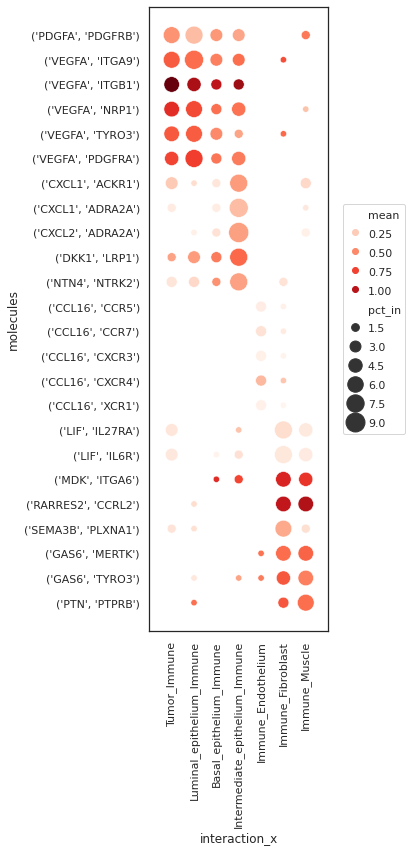

In [120]:
keys_subset = keys.copy()
#keys_subset =[k for i,k in enumerate(keys) if i in [0,2,3,5,6]]

plot_df = format_dotplot_df(summarized_ligrec_df,keys_subset,n_interactions_per_interface=5, filter_by_n_regions = 1, filter_duplicates=False)
#plot_df = summarized_ligrec_df.loc[idx].copy()

plot_df['molecules'] = plot_df['molecules'].astype(str)

# Create the dotplot
sns.set(style='white')

width = 6
height = 12


fig, ax = plt.subplots(figsize=(width, height))

xticks_list = list(np.arange(2,(len(keys_subset)*2)+2,2))

# Get control over interactions order and gap
plot_df['interaction_x'] = plot_df['interaction'].map(dict(zip(keys_subset,xticks_list)))

sns.scatterplot(x='interaction_x', y='molecules', size='pct_in', hue='mean', data=plot_df, sizes=(40, 400), palette='Reds', ax=ax)

plt.xlim(0,xticks_list[-1]+2)
#plt.yticks([0,1,2,3,4,5])
plt.xticks(xticks_list,keys_subset,rotation=90)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()


""" if reverse_switch:
    plt.savefig('./plots/interface_ligrec_dotplots/ligrec_to_'+roi+'_dotplot.pdf')
else:
    plt.savefig('./plots/interface_ligrec_dotplots/ligrec_from_'+roi+'_dotplot.pdf')
 """

plt.show()




In [ ]:
# The most common receptors
print('Top ligands')
print(pd.Series([idx[0] for idx in plot_df.index.unique()]).value_counts()[:5])
print()
print('Top receptors')
print(pd.Series([idx[1] for idx in plot_df.index.unique()]).value_counts()[:5])

### Visualizing chemotaxis/cytokines in interface interactions

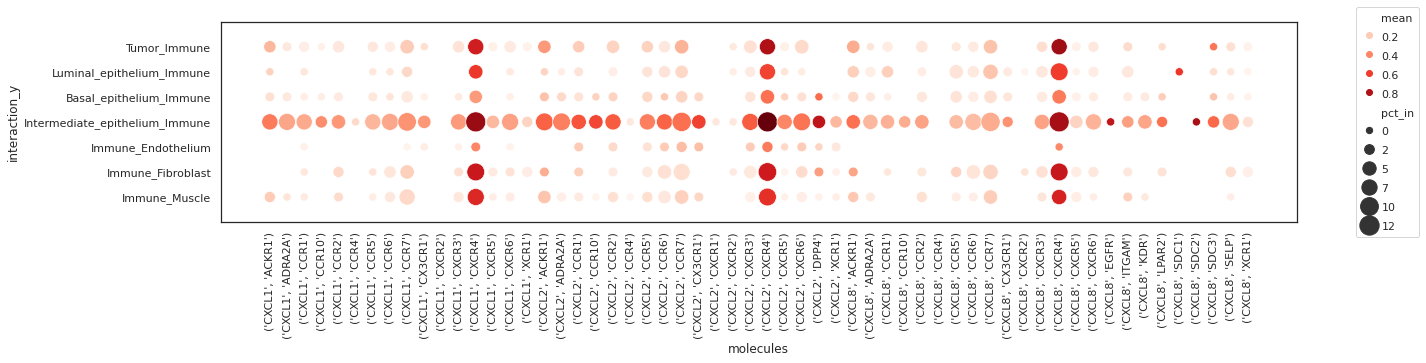

In [121]:
ligands = ['CXCL1','CXCL2','CXCL8']
filter_mask = summarized_ligrec_df.index.get_level_values(0).isin(ligands)
plot_df = summarized_ligrec_df.loc[filter_mask]

plot_df['molecules'] = plot_df['molecules'].astype(str)

plot_df.sort_index(inplace=True)

# Create the dotplot
sns.set(style='white')

width = 20
height = 5


fig, ax = plt.subplots(figsize=(width, height))

yticks_list = list(np.arange(2,(len(keys_subset)*2)+2,2)[::-1])

# Get control over interactions order and gap
plot_df['interaction_y'] = plot_df['interaction'].map(dict(zip(keys_subset,yticks_list)))

sns.scatterplot(x='molecules', y='interaction_y', size='pct_in', hue='mean', data=plot_df, sizes=(40, 400), palette='Reds', ax=ax)

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,keys_subset,rotation=0)
plt.xticks(rotation=90)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.show()

In [166]:
df = plot_df.copy()
df['ligand'] = df.index.get_level_values(0)
df['receptor'] = df.index.get_level_values(1)
df = df[['mean','pct_in','ligand','interaction']].groupby(['ligand','interaction']).mean()
df['ligand'] = df.index.get_level_values(0)
df['interaction'] = df.index.get_level_values(1)
df

mean    pct_in ligand  \
ligand interaction                                                 
CXCL1  Basal_epithelium_Immune         0.098676  1.642857  CXCL1   
       Immune_Endothelium              0.099881  1.000000  CXCL1   
       Immune_Fibroblast               0.175196  3.090909  CXCL1   
       Immune_Muscle                   0.154893  2.833333  CXCL1   
       Intermediate_epithelium_Immune  0.342766  6.687500  CXCL1   
       Luminal_epithelium_Immune       0.185442  2.000000  CXCL1   
       Tumor_Immune                    0.141178  3.357143  CXCL1   
CXCL2  Basal_epithelium_Immune         0.195501  2.062500  CXCL2   
       Immune_Endothelium              0.197825  1.714286  CXCL2   
       Immune_Fibroblast               0.176261  3.500000  CXCL2   
       Immune_Muscle                   0.120705  3.062500  CXCL2   
       Intermediate_epithelium_Immune  0.450988  7.000000  CXCL2   
       Luminal_epithelium_Immune       0.137975  2.666667  CXCL2   
       Tumor_Immune                    0.222085  3.333333  CXCL2   
CXCL8  Basal_epithelium_Immune         0.114538  2.200000  CXCL8   
       Immune_Endothelium              0.393426  1.000000  CXCL8   
       Immune_Fibroblast               0.164397  2.888889  CXCL8   
       Immune_Muscle                   0.148451  2.058824  CXCL8   
       Intermediate_epithelium_Immune  0.378092  5.347826  CXCL8   
       Luminal_epithelium_Immune       0.151885  3.277778  CXCL8   
       Tumor_Immune                    0.184178  2.285714  CXCL8   

                                                          interaction  
ligand interaction                                                     
CXCL1  Basal_epithelium_Immune                Basal_epithelium_Immune  
       Immune_Endothelium                          Immune_Endothelium  
       Immune_Fibroblast                            Immune_Fibroblast  
       Immune_Muscle                                    Immune_Muscle  
       Intermediate_epithelium_Immune  Intermediate_epithelium_Immune  
       Luminal_epithelium_Immune            Luminal_epithelium_Immune  
       Tumor_Immune                                      Tumor_Immune  
CXCL2  Basal_epithelium_Immune                Basal_epithelium_Immune  
       Immune_Endothelium                          Immune_Endothelium  
       Immune_Fibroblast                            Immune_Fibroblast  
       Immune_Muscle                                    Immune_Muscle  
       Intermediate_epithelium_Immune  Intermediate_epithelium_Immune  
       Luminal_epithelium_Immune            Luminal_epithelium_Immune  
       Tumor_Immune                                      Tumor_Immune  
CXCL8  Basal_epithelium_Immune                Basal_epithelium_Immune  
       Immune_Endothelium                          Immune_Endothelium  
       Immune_Fibroblast                            Immune_Fibroblast  
       Immune_Muscle                                    Immune_Muscle  
       Intermediate_epithelium_Immune  Intermediate_epithelium_Immune  
       Luminal_epithelium_Immune            Luminal_epithelium_Immune  
       Tumor_Immune                                      Tumor_Immune

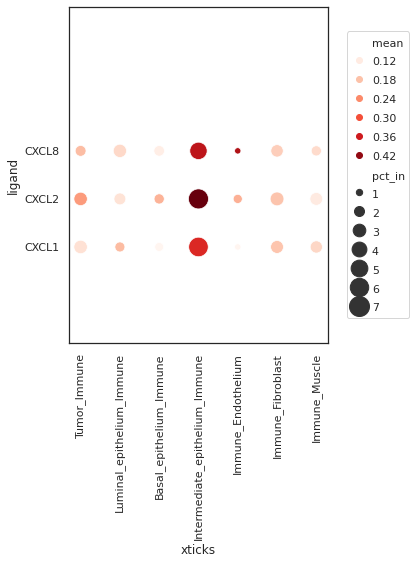

In [177]:
# Create the dotplot
sns.set(style='white')

width = 6
height = 8

fig, ax = plt.subplots(figsize=(width, height))

xticks_list = list(np.arange(2,(len(keys)*2)+2,2))

# Get control over interactions order and gap
df['xticks'] = df['interaction'].map(dict(zip(keys,xticks_list)))

sns.scatterplot(x='xticks', y='ligand', size='pct_in', hue='mean', data=df, sizes=(40, 400), palette='Reds', ax=ax)

plt.ylim(-2,len(ligands)+2)
plt.xticks(xticks_list,keys,rotation=90)

plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.show()

### Plotting heatmap of mean values

In [ ]:
merged_df = pd.merge(tumor_immune_means_df,inter_immune_means_df,how='outer',left_index=True,right_index=True)

# This is the column index where region comparison changes
n_samples = len(samples_unt)
max_zero_entries_allowed = 5
n_show = 20

# Experimental: Drop samples that have more than 'extra' samples in either category empty
merged_df = merged_df.loc[merged_df.isna().sum(axis=1) <= max_zero_entries_allowed]

# Calculate the signaling molecules with the highest mean difference
region_intensity_diff = (merged_df[merged_df.columns[:n_samples]].sum(axis=1)-merged_df[merged_df.columns[n_samples:]].sum(axis=1)).sort_values(ascending=True)

idx_1 = region_intensity_diff[-n_show:].sort_index().index.tolist()
idx_2 = region_intensity_diff[:n_show].sort_index().index.tolist()
idxs = idx_1+idx_2

plot_df = merged_df.loc[idxs]
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(plot_df,cmap='Reds',xticklabels=False,ax=ax)
plt.show()

### Categorical heatmap of signifcant signaling

In [ ]:
n_samples = len(samples_unt)
merged_df = pd.merge(tumor_immune_means_df,inter_immune_means_df,how='outer',left_index=True,right_index=True)
tumor_immune = merged_df[merged_df.columns[:n_samples]]
inter_immune = merged_df[merged_df.columns[n_samples:]]
tumor_immune.columns = samples_unt
inter_immune.columns = samples_unt

In [ ]:
def calculate_ligrec_agreement(df1,df2):
    # Create a boolean mask for each dataframe where True indicates NaN values
    mask1 = df1.isna()
    mask2 = df2.isna()

    # Initialize the third dataframe with NaN values of the same shape as the other dataframes
    df3 = pd.DataFrame(np.nan, index=mask1.index, columns= mask1.columns)

    # Assign values to the third dataframe based on the conditions
    #df3[(mask1) & (mask2)] = 0 # Try setting values where both active to 0
    df3[(~mask1) & (~mask2)] = 0
    df3[(~mask1) & (mask2)] = -1
    df3[(mask1) & (~mask2)] = 1
    
    return(df3)

In [ ]:
df = calculate_ligrec_agreement(tumor_immune,inter_immune)

max_zero_entries_allowed = 3
df = df.loc[df.isna().sum(axis=1) <= max_zero_entries_allowed]


In [ ]:
n_rows_total = 30
# Define the custom colormap
sns.set_theme(style='white')
cmap_colors = [color_dict['Tumor'], '#000000', color_dict['Intermediate epithelium']]
cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

new_col_order = df.isna().sum().sort_values(ascending=True).index
new_row_order = df.sum(axis=1).sort_values()
rows1 = new_row_order[:int(n_rows_total/2)].sort_index().index.tolist()
rows2 = new_row_order[-int(n_rows_total/2):].sort_index().index.tolist()
new_rows =  rows1 + rows2

df_to_plot = df.loc[new_rows][new_col_order]
fig,ax = plt.subplots(figsize=(6,20))
sns.heatmap(df_to_plot,cmap=cmap,xticklabels=True,square=True,cbar=False)


## Inspecting ligand-receptor interaction results in treatment context

In [ ]:
def print_signif_fishers_results(df, n_untreated, n_treated, signif_level=0.05):

    for name,row in df.iterrows():
        untreat_signif = row[0]
        treat_signif  = row[1]

        contingency_table = np.array([[untreat_signif, n_untreated-untreat_signif], [treat_signif, n_treated-treat_signif]],dtype=int)

        if row.loc['p_value'] < signif_level:
            print(name[0]+' --> '+ name[1])
            print(contingency_table)
            print("Odds Ratio: {:.1f}".format(row.loc['odds_ratio']))
            print("p-value: {:.2e}".format(row.loc['p_value']))
            print('')

def calculate_fishers(dataframe,n_untreated,n_treated):


    odds_ratios = []
    p_values = []

    for name,row in dataframe.iterrows():
        untreat_signif = row[0]
        treat_signif  = row[1]

        contingency_table = np.array([[untreat_signif, n_untreated-untreat_signif], [treat_signif, n_treated-treat_signif]])
        odds_ratio, p_value = fisher_exact(contingency_table)

        odds_ratios.append(odds_ratio)
        p_values.append(p_value)

    # p_values is a list of p-values
    #corrected_pvalues = multipletests(np.array(p_values), method='fdr_bh')[1]

    dataframe['odds_ratio'] = odds_ratios
    dataframe['p_value'] = p_values
    #dataframe['corr_p_value'] = corrected_pvalues

    return(dataframe)


In [ ]:
from scripts.utils import get_treatment_info
treatment_info = get_treatment_info()
divider = ' \n #################################################################### \n '

In [ ]:
# Calculate and print the significant p-values for fisher's exact tests between these comparisons
tup_list = [('Basal epithelium','Cancer epithelium'),
            ('Basal epithelium','Luminal epithelium'),
            ('Interferon signaling epithelium','Immune'),
            ('Immune','Interferon signaling epithelium'),
            ('Immune','Cancer epithelium'),
            ('Cancer epithelium','Basal epithelium'),
            ('Cancer epithelium','Interferon signaling epithelium'),
            ('Cancer epithelium','Fibroblast'),
            ('Cancer epithelium','Luminal epithelium'),
            ('Cancer epithelium','Immune')
            ]
for tup in tup_list:
    print(tup)
    source = tup[0]
    target = tup[1]

    ligand_receptor_dict = load_from_pickle('data/'+source+'_to_'+target+'_ligand_receptor_proximity_interactions.pickle')

    treated = {}
    untreated = {}

    for s in ligand_receptor_dict.keys():

        if (treatment_info[s] == 'goserelin') | (treatment_info[s] == 'bicalutamide'): 
            treated[s] = ligand_receptor_dict[s]

        if (treatment_info[s] == 'untreated'):
            untreated[s] = ligand_receptor_dict[s]
            

    treated_most_common = most_common_interactions(treated)
    untreated_most_common = most_common_interactions(untreated)
    merged_dict = merge_dicts(untreated_most_common,treated_most_common)

    df = pd.DataFrame(merged_dict,index=[
        'untreated '+ '('+str(len(untreated))+')',
        'treated  '+ '('+str(len(treated))+')',
        'diff']).T.sort_values('diff',ascending=False)

    ligands = np.array([tup[0] for tup in list(df.index)])
    _, idx = np.unique(ligands, return_index=True)
    ligands = ligands[np.sort(idx)].tolist()

    receptors = np.array([tup[1] for tup in list(df.index)])
    _, idx = np.unique(receptors, return_index=True)
    receptors = receptors[np.sort(idx)].tolist()

    df_res = calculate_fishers(df[np.abs(df['diff'])>5],len(untreated),len(treated))
    print_signif_fishers_results(df_res,len(untreated),len(treated))

    print(divider)